# Behavior Example Notebook

In [1]:
from stream_nwbfile import stream_nwbfile
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

This notebook showcases one example session from the 001617 dataset containing labeled sleep/wake behavior, concurrent electrophysiology recordings, and DeepLabCut pose estimation.

In [2]:
DANDISET_ID = '001617'
file_path = 'sub-M405-M407/sub-M405-M407_ses-M405-M407-250412-081001_ecephys+image.nwb'
nwbfile, io = stream_nwbfile(DANDISET_ID, file_path)
display(nwbfile)

A newer version (0.71.4) of dandi/dandi-cli is available. You are using 0.67.2


Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,undefined
Data type,object
Shape,"(1,)"
Array size,8.00 bytes
Chunk shape,None


Get Sleep/Wake Data

In [3]:
epochs_df = nwbfile.epochs.to_dataframe()
all_wake = np.array([['WAKE'] * len(epochs_df)])[0]
all_rem = np.array([['REM'] * len(epochs_df)])[0]
all_nrem = np.array([['NREM'] * len(epochs_df)])[0]
wake_df = epochs_df[epochs_df.tags == all_wake]
rem_df = epochs_df[epochs_df.tags == all_rem]
nrem_df = epochs_df[epochs_df.tags == all_nrem]

Plot Sleep/Wake Data

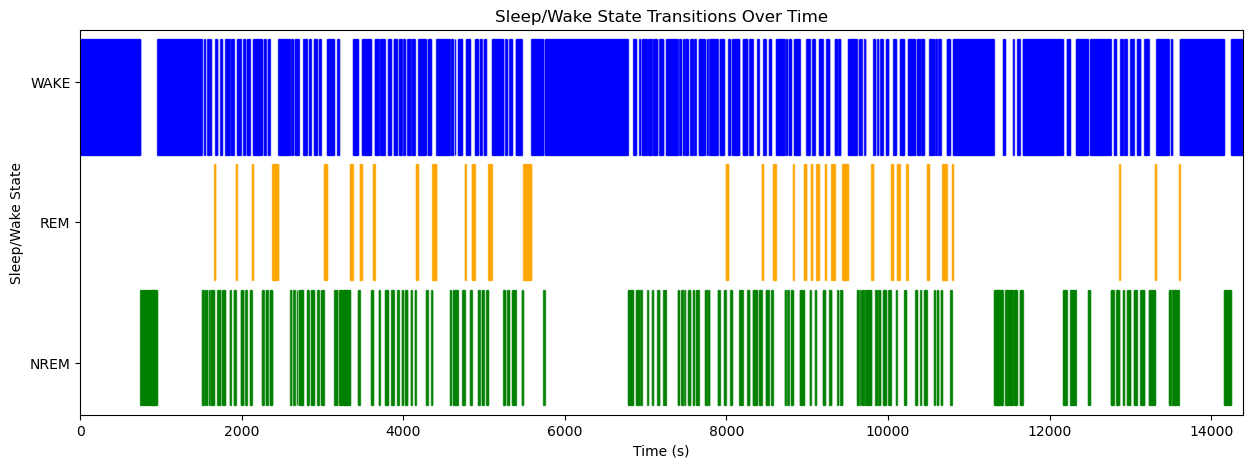

In [4]:
plt.figure(figsize=(15, 5))

# Plot each state as horizontal spans with spacing
for _, row in wake_df.iterrows():
    plt.axvspan(row.start_time, row.stop_time, ymin=0.675, ymax=0.975, color='blue', alpha=0.7)
    
for _, row in rem_df.iterrows():
    plt.axvspan(row.start_time, row.stop_time, ymin=0.35, ymax=0.65, color='orange', alpha=0.7)
    
for _, row in nrem_df.iterrows():
    plt.axvspan(row.start_time, row.stop_time, ymin=0.025, ymax=0.325, color='green', alpha=0.7)

plt.yticks([0.135, 0.5, 0.865], ['NREM', 'REM', 'WAKE'])
plt.xlabel('Time (s)')
plt.ylabel('Sleep/Wake State')
plt.title('Sleep/Wake State Transitions Over Time')
plt.xlim(0, epochs_df.stop_time.max())
plt.show()


Get Electrophysiology Data

In [5]:
eeg_data = nwbfile.processing["ecephys"].data_interfaces["ElectricalSeriesEEG"].data[:]
eeg_data_in_uV = eeg_data * nwbfile.processing["ecephys"].data_interfaces["ElectricalSeriesEEG"].conversion * 1e6
emg_data = nwbfile.processing["ecephys"].data_interfaces["ElectricalSeriesEMG"].data[:]
emg_data_in_uV = emg_data * nwbfile.processing["ecephys"].data_interfaces["ElectricalSeriesEMG"].conversion * 1e6
ephys_starting_time = nwbfile.processing["ecephys"].data_interfaces["ElectricalSeriesEEG"].starting_time
ephys_rate = nwbfile.processing["ecephys"].data_interfaces["ElectricalSeriesEEG"].rate
ephys_timestamps = np.arange(ephys_starting_time, ephys_starting_time + (len(eeg_data) / ephys_rate), 1 / ephys_rate)

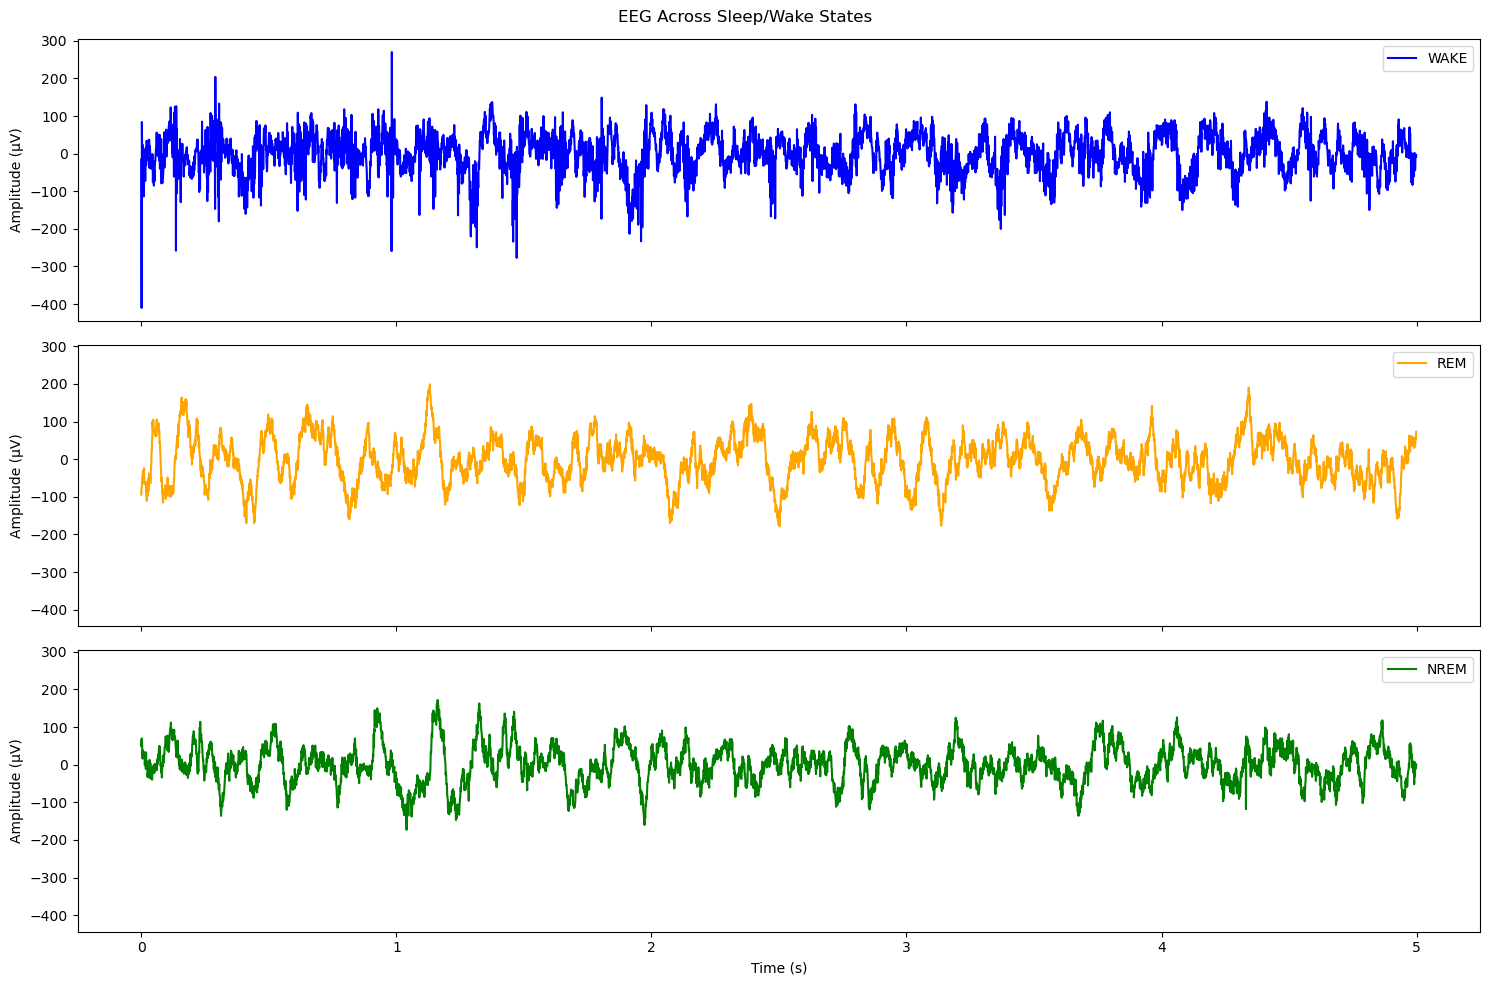

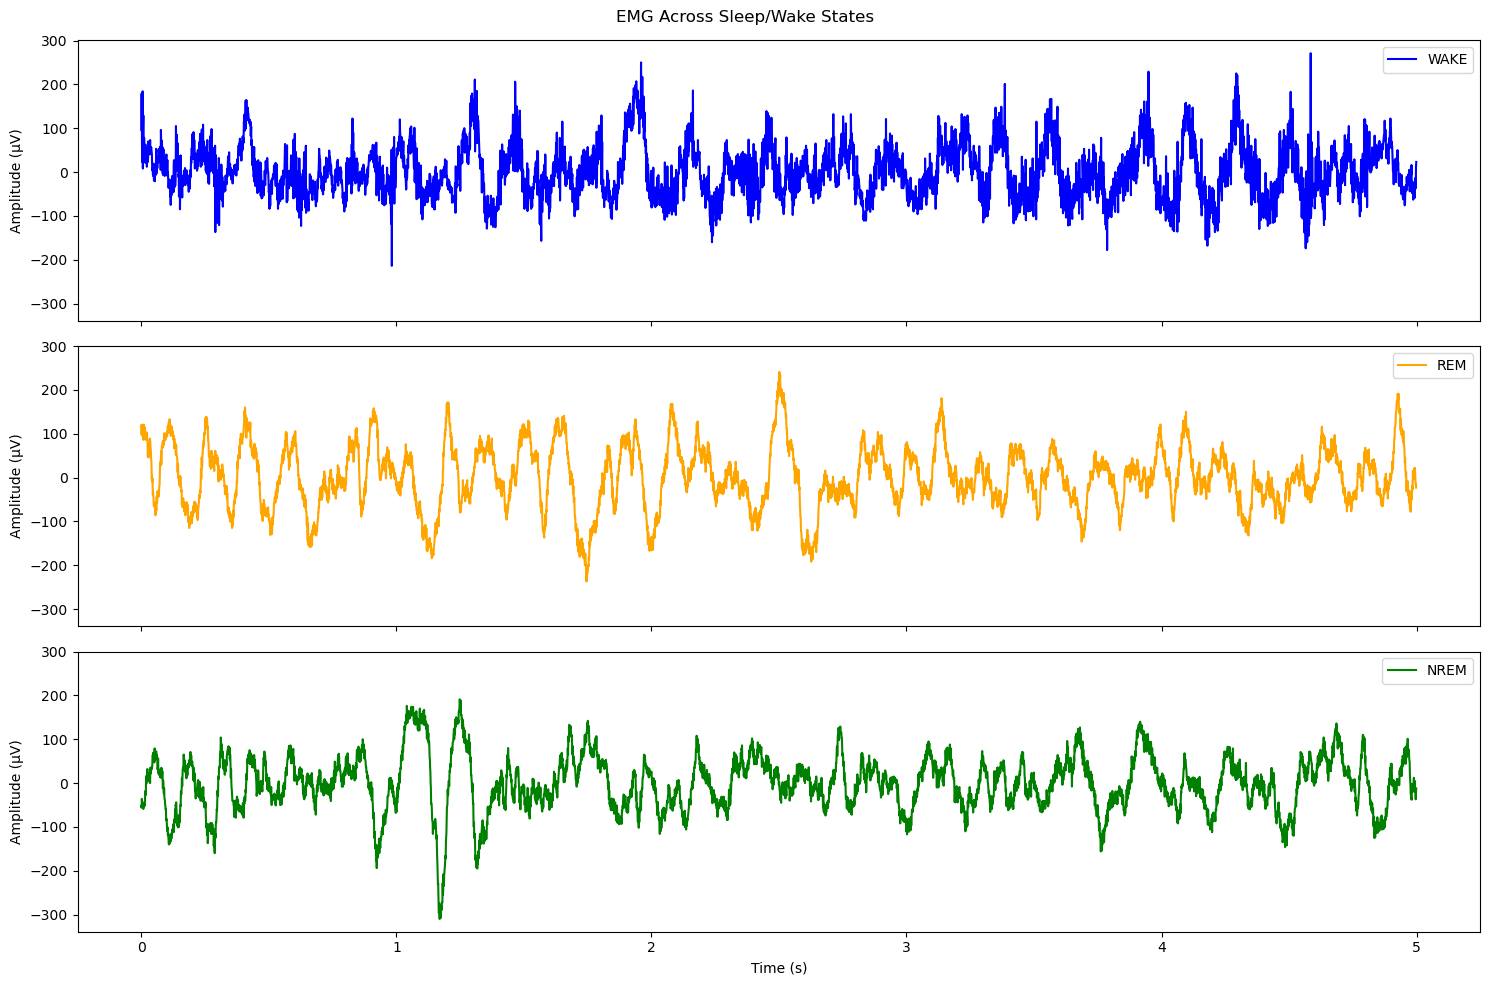

In [6]:
example_wake = wake_df.iloc[0]
example_rem = rem_df.iloc[0]
example_nrem = nrem_df.iloc[0]

# Define time windows for plotting
start_time_wake = example_wake["start_time"]
stop_time_wake = example_wake["stop_time"]
wake_slice = slice(int(start_time_wake * ephys_rate), int(stop_time_wake * ephys_rate))
start_time_rem = example_rem["start_time"]
stop_time_rem = example_rem["stop_time"]
rem_slice = slice(int(start_time_rem * ephys_rate), int(stop_time_rem * ephys_rate))
start_time_nrem = example_nrem["start_time"]
stop_time_nrem = example_nrem["stop_time"]
nrem_slice = slice(int(start_time_nrem * ephys_rate), int(stop_time_nrem * ephys_rate))

# Normalize times to start at 0 for each state
normalized_wake_timestamps = ephys_timestamps[wake_slice] - start_time_wake
normalized_rem_timestamps = ephys_timestamps[rem_slice] - start_time_rem
normalized_nrem_timestamps = ephys_timestamps[nrem_slice] - start_time_nrem

# Plot EEG data for all states in one figure
fig_eeg, (ax_eeg_wake, ax_eeg_rem, ax_eeg_nrem) = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)

ax_eeg_wake.plot(normalized_wake_timestamps, eeg_data_in_uV[wake_slice], color='blue', label='WAKE')
ax_eeg_wake.set_ylabel('Amplitude (µV)')
ax_eeg_wake.legend()

ax_eeg_rem.plot(normalized_rem_timestamps, eeg_data_in_uV[rem_slice], color='orange', label='REM')
ax_eeg_rem.set_ylabel('Amplitude (µV)')
ax_eeg_rem.legend()

ax_eeg_nrem.plot(normalized_nrem_timestamps, eeg_data_in_uV[nrem_slice], color='green', label='NREM')
ax_eeg_nrem.set_ylabel('Amplitude (µV)')
ax_eeg_nrem.set_xlabel('Time (s)')
ax_eeg_nrem.legend()

fig_eeg.suptitle('EEG Across Sleep/Wake States')
plt.tight_layout()

# Plot EMG data for all states in one figure
fig_emg, (ax_emg_wake, ax_emg_rem, ax_emg_nrem) = plt.subplots(3, 1, figsize=(15, 10), sharex=True, sharey=True)

ax_emg_wake.plot(normalized_wake_timestamps, emg_data_in_uV[wake_slice], color='blue', label='WAKE')
ax_emg_wake.set_ylabel('Amplitude (µV)')
ax_emg_wake.legend()

ax_emg_rem.plot(normalized_rem_timestamps, emg_data_in_uV[rem_slice], color='orange', label='REM')
ax_emg_rem.set_ylabel('Amplitude (µV)')
ax_emg_rem.legend()

ax_emg_nrem.plot(normalized_nrem_timestamps, emg_data_in_uV[nrem_slice], color='green', label='NREM')
ax_emg_nrem.set_ylabel('Amplitude (µV)')
ax_emg_nrem.set_xlabel('Time (s)')
ax_emg_nrem.legend()

fig_emg.suptitle('EMG Across Sleep/Wake States')
plt.tight_layout()

Get Pose Estimation Data

In [7]:
pose_estimation = nwbfile.processing["behavior"].data_interfaces["PoseEstimationDeepLabCut"]
        
nodes = pose_estimation.skeleton.nodes[:]
edges = pose_estimation.skeleton.edges or []
pes = pose_estimation.pose_estimation_series
name_to_data = {name: series.data[:] for name, series in pes.items()}
pes_starting_time = pes["PoseEstimationSeriesCenterbody1"].starting_time
pes_rate = pes["PoseEstimationSeriesCenterbody1"].rate
pes_timestamps = np.arange(len(next(iter(name_to_data.values())))) / pes_rate + pes_starting_time
node_to_name = {node: f"PoseEstimationSeries{node.capitalize()}" for node in nodes}

In [8]:
def plot_pose_estimation(nodes, edges, name_to_data, node_to_name, timestamps):
    """
    Plot pose estimation data with trajectory and skeleton structure.
    
    Parameters:
    -----------
    nodes : array-like
        Node names for the pose estimation skeleton
    edges : array-like
        Edge connections between nodes
    name_to_data : dict
        Dictionary mapping node names to position data
    node_to_name : dict
        Dictionary mapping node indices to series names
    timestamps : array-like
        Timestamps for the pose estimation data
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: Average position scatter plot with trajectory
    all_x = np.array([name_to_data[node_to_name[node]][:, 0] for node in nodes])
    all_y = np.array([name_to_data[node_to_name[node]][:, 1] for node in nodes])

    x = np.nanmean(all_x, axis=0)
    y = np.nanmean(all_y, axis=0)

    sc = ax1.scatter(x, y, c=timestamps, cmap='viridis', s=1)
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_title('Average Position Trajectory')
    plt.colorbar(sc, ax=ax1, label='Time (s)')
    
    # Right plot: Network graph using networkx
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes
    for i, node in enumerate(nodes):
        G.add_node(i, label=node)
    
    # Add edges
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    
    # Create layout
    pos = nx.spring_layout(G, seed=42)
    
    # Draw the network
    nx.draw(G, pos, ax=ax2, with_labels=True, 
            labels={i: nodes[i] for i in range(len(nodes))},
            node_color='lightblue', node_size=1000, 
            font_size=10, font_weight='bold',
            edge_color='gray', width=2)
    
    ax2.set_title('Pose Estimation Skeleton Structure')
    ax2.axis('off')
    
    plt.tight_layout()

    return fig, (ax1, ax2)

(<Figure size 2000x800 with 3 Axes>,
 (<Axes: title={'center': 'Average Position Trajectory'}, xlabel='X Position', ylabel='Y Position'>,
  <Axes: title={'center': 'Pose Estimation Skeleton Structure'}>))

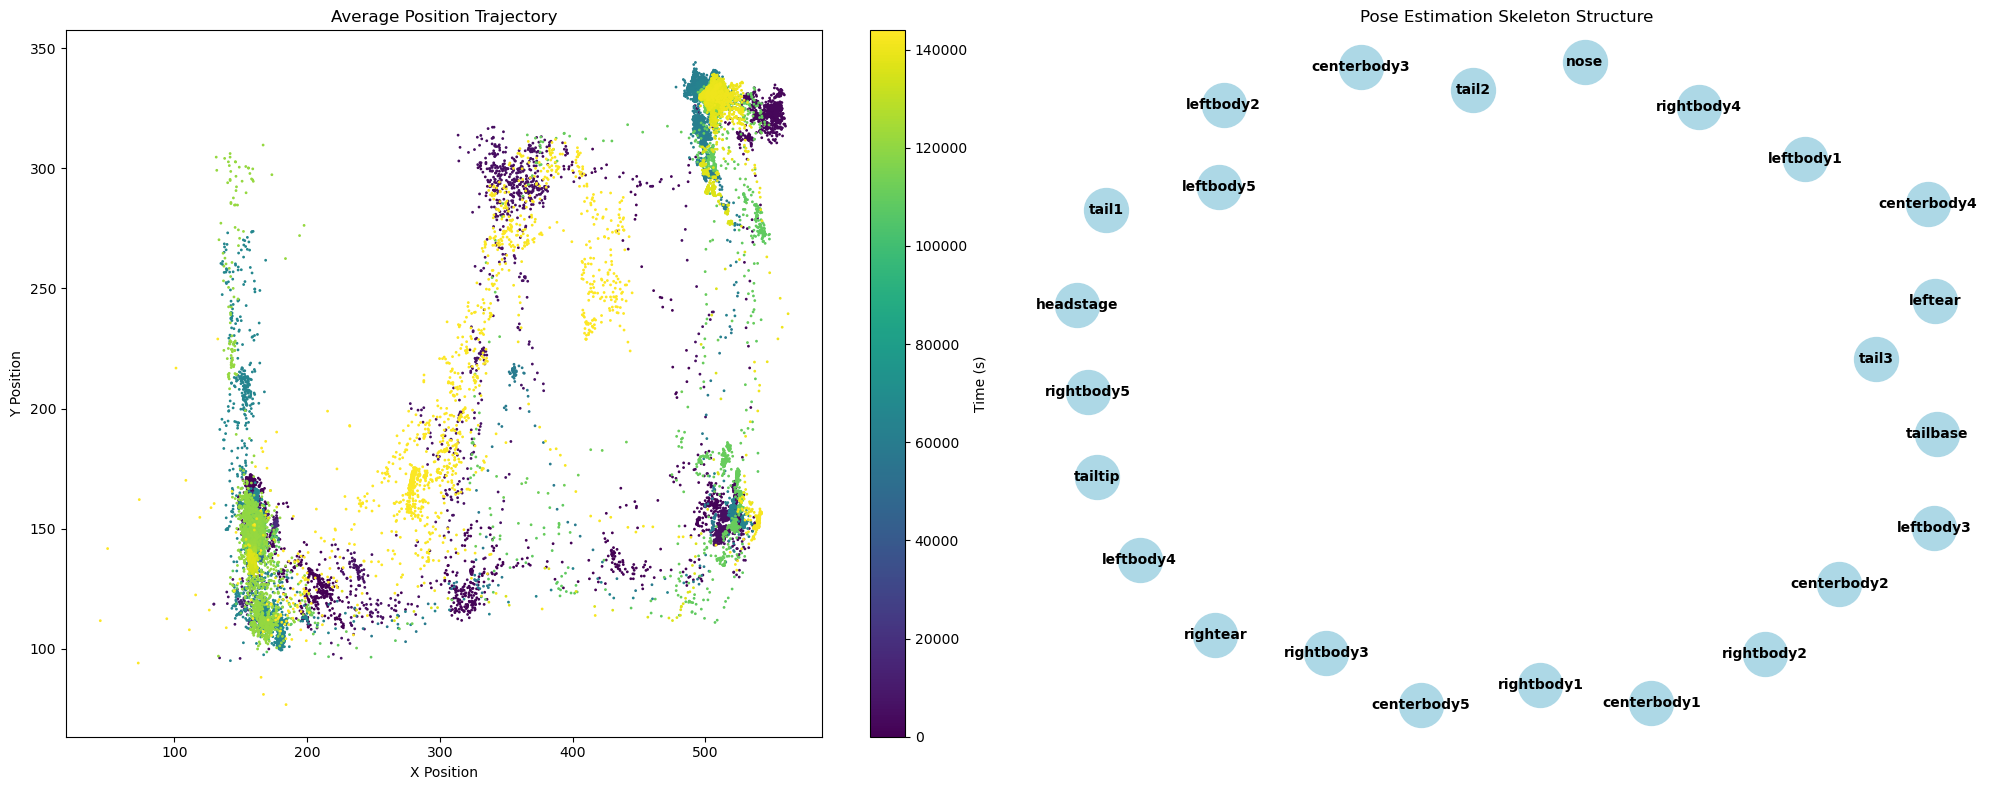

In [9]:
plot_pose_estimation(nodes, edges, name_to_data, node_to_name, pes_timestamps)